In [7]:
from pydantic_ai import Agent, RunContext
from time import sleep
import nest_asyncio
nest_asyncio.apply()

In [8]:

roulette_agent = Agent(
    'google-gla:gemini-1.5-flash',
    deps_type=int,
    result_type=bool,
    system_prompt=(
        'Use the `roulette_wheel` function to see if the '
        'customer has won based on the number they provide.'
    ),
)


@roulette_agent.tool
async def roulette_wheel(ctx: RunContext[int], square: int) -> str:
    """check if the square is a winner"""
    return 'winner' if square == ctx.deps else 'loser'


# Run the agent
success_number = 18
result = roulette_agent.run_sync('Put my money on square eighteen', deps=success_number)
print(result.data)
#> True

result = roulette_agent.run_sync('I bet five is the winner', deps=success_number)
print(result.data)
#> False

True
False


/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/unittest/mock.py:2217: RuntimeWarning: coroutine 'Agent.run' was never awaited
  def __init__(self, name, parent):


John Doe
John Doe
John Doe
John Doe
John Doe
Get me foobar.
{'properties': {'a': {'description': 'apple pie', 'title': 'A', 'type': 'integer'}, 'b': {'description': 'banana cake', 'title': 'B', 'type': 'string'}, 'c': {'additionalProperties': {'items': {'type': 'number'}, 'type': 'array'}, 'description': 'carrot smoothie', 'title': 'C', 'type': 'object'}}, 'required': ['a', 'b', 'c'], 'type': 'object', 'additionalProperties': False}
Get me foobar.
{'properties': {'a': {'description': 'apple pie', 'title': 'A', 'type': 'integer'}, 'b': {'description': 'banana cake', 'title': 'B', 'type': 'string'}, 'c': {'additionalProperties': {'items': {'type': 'number'}, 'type': 'array'}, 'description': 'carrot smoothie', 'title': 'C', 'type': 'object'}}, 'required': ['a', 'b', 'c'], 'type': 'object', 'additionalProperties': False}
Get me foobar.
{'properties': {'a': {'description': 'apple pie', 'title': 'A', 'type': 'integer'}, 'b': {'description': 'banana cake', 'title': 'B', 'type': 'string'}, 'c'

In [11]:
from pydantic_ai import Agent

agent = Agent('google-gla:gemini-1.5-flash')

result_sync = agent.run_sync('What is the capital of Italy?')
print(result_sync.data)
#> Rome


#sync def main():
result = await agent.run('What is the capital of France?')
print(result.data)
#> Paris

async with agent.run_stream('What is the capital of the UK?') as response:
    print(await response.get_data())
    #> London

Rome

Paris

London



In [13]:
from pydantic_ai import Agent
from pydantic_ai.exceptions import UsageLimitExceeded
from pydantic_ai.usage import UsageLimits

agent = Agent('google-gla:gemini-1.5-flash')

result_sync = agent.run_sync(
    'What is the capital of Italy? Answer with just the city.',
    usage_limits=UsageLimits(response_tokens_limit=10),
)
print(result_sync.data)
#> Rome
print(result_sync.usage())
"""
Usage(requests=1, request_tokens=62, response_tokens=1, total_tokens=63, details=None)
"""

try:
    result_sync = agent.run_sync(
        'What is the capital of Italy? Answer with a paragraph.',
        usage_limits=UsageLimits(response_tokens_limit=10),
    )
except UsageLimitExceeded as e:
    print(e)
    #> Exceeded the response_tokens_limit of 10 (response_tokens=32)

Rome

Usage(requests=1, request_tokens=13, response_tokens=2, total_tokens=15, details=None)
Exceeded the response_tokens_limit of 10 (response_tokens=73)


In [14]:
from typing_extensions import TypedDict

from pydantic_ai import Agent, ModelRetry
from pydantic_ai.exceptions import UsageLimitExceeded
from pydantic_ai.usage import UsageLimits


class NeverResultType(TypedDict):
    """
    Never ever coerce data to this type.
    """

    never_use_this: str


agent = Agent(
    'google-gla:gemini-1.5-flash',
    retries=3,
    result_type=NeverResultType,
    system_prompt='Any time you get a response, call the `infinite_retry_tool` to produce another response.',
)


@agent.tool_plain(retries=5)  
def infinite_retry_tool() -> int:
    raise ModelRetry('Please try again.')


try:
    result_sync = agent.run_sync(
        'Begin infinite retry loop!', usage_limits=UsageLimits(request_limit=3)  
    )
except UsageLimitExceeded as e:
    print(e)
    #> The next request would exceed the request_limit of 3


The next request would exceed the request_limit of 3


In [16]:
result_sync = agent.run_sync(
    'What is the capital of Italy?', model_settings={'temperature': 1.0}
)
print(result_sync.data)

{'never_use_this': 'Rome'}


In [17]:
from pydantic_ai import Agent, UnexpectedModelBehavior
from pydantic_ai.models.gemini import GeminiModelSettings

agent = Agent('google-gla:gemini-1.5-flash')

try:
    result = agent.run_sync(
        'Write a list of 5 very rude things that I might say to the universe after stubbing my toe in the dark:',
        model_settings=GeminiModelSettings(
            temperature=0.0,  # general model settings can also be specified
            gemini_safety_settings=[
                {
                    'category': 'HARM_CATEGORY_HARASSMENT',
                    'threshold': 'BLOCK_LOW_AND_ABOVE',
                },
                {
                    'category': 'HARM_CATEGORY_HATE_SPEECH',
                    'threshold': 'BLOCK_LOW_AND_ABOVE',
                },
            ],
        ),
    )
except UnexpectedModelBehavior as e:
    print(e)  
    """
    Safety settings triggered, body:
    <safety settings details>
    """

Safety settings triggered, body:
{'candidates': [{'finish_reason': 'SAFETY', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE'}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'LOW', 'blocked': True}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE'}]}], 'usage_metadata': {'prompt_token_count': 25, 'total_token_count': 25}, 'model_version': 'gemini-1.5-flash'}


In [23]:
from rich.markdown import Markdown
# First run
result1 = agent.run_sync('Who was Albert Einstein?')
display(Markdown(result1.data))
#> Albert Einstein was a German-born theoretical physicist.

# Second run, passing previous messages
result2 = agent.run_sync(
    'What was his most famous equation?',
    message_history=result1.new_messages(),  
)
Markdown(result2.data)
#> Albert Einstein's most famous equation is (E = mc^2).

Albert Einstein (1879-1955) was a German-born theoretical physicist who developed the theory of relativity, one of 
the two pillars of modern physics (alongside quantum mechanics).  His work is also known for its influence on the  
philosophy of science.                                                                                             

He is best known for his mass–energy equivalence formula  E=mc², which has been dubbed "the world's most famous    
equation".  His contributions to physics include:                                                                  

 • The Special Theory of Relativity: This theory revolutionized our understanding of space, time, gravity, and the 
   universe at large, showing that space and time are relative and interconnected.                                 
 • The General Theory of Relativity:  An extension of the special theory, this theory provided a new understanding 
   of gravity as a curvature of spacetime caused by mass and energy.  It predicted phenomena like gravitational    
   lensing and gravitational waves, which have since been observed.                                                
 • The Photoelectric Effect: His explanation of this phenomenon, which describes how light can knock electrons off 
   a metal surface, earned him the Nobel Prize in Physics in 1921.  This work was crucial for the development of   
   quantum mechanics.                                                                                              

Beyond his scientific achievements, Einstein was a humanist and pacifist who was deeply concerned about social     
justice and the potential dangers of unchecked technological advancement. He became a cultural icon, representing  
genius and intellectual curiosity.  He is considered one of the most influential scientists of all time.

His most famous equation is E=mc².

result1

In [49]:
from dataclasses import dataclass

from pydantic_ai import Agent, RunContext


@dataclass
class User:
    name: str


agent = Agent(
    'google-gla:gemini-1.5-flash',
    deps_type=User,  
    result_type=bool,
)


@agent.system_prompt
def add_user_name(ctx: RunContext[str]) -> str:  
    return f"The user's name is {ctx.deps}."


def foobar(x: bytes) -> None:
    pass


result = agent.run_sync('Does their name start with "A"?', deps=User('Bnne'))
result.data

False

result1

In [74]:
from datetime import date

from pydantic_ai import Agent, RunContext

agent = Agent(
    'google-gla:gemini-1.5-flash',
    deps_type=str,  
    system_prompt="Use the customer's name while replying to them.",  
)


@agent.system_prompt  
def add_the_users_name(ctx: RunContext[str]) -> str:
    return f"The user's name is {ctx.deps}."


@agent.system_prompt
def add_the_date() -> str:  
    return f'The date is {date.today()}.'


result = agent.run_sync('What is the date?', deps='Frank')
print(result.data)
#> Hello Frank, the date today is 2032-01-02.

Frank, today is February 16th, 2025.



In [73]:
for m in result1._all_messages:
    print (m.kind)
    if m.kind == "request": 
        for part in m.parts:
            print (part.content)
    if m.kind == "response": 
        for part in m.parts:
            print (part.content)

request
Who was Albert Einstein?
response
Albert Einstein (1879-1955) was a German-born theoretical physicist who developed the theory of relativity, one of the two pillars of modern physics (alongside quantum mechanics).  His work is also known for its influence on the philosophy of science.

He is best known for his mass–energy equivalence formula  E=mc², which has been dubbed "the world's most famous equation".  His contributions to physics include:

* **The Special Theory of Relativity:** This theory revolutionized our understanding of space, time, gravity, and the universe at large, showing that space and time are relative and interconnected.
* **The General Theory of Relativity:**  An extension of the special theory, this theory provided a new understanding of gravity as a curvature of spacetime caused by mass and energy.  It predicted phenomena like gravitational lensing and gravitational waves, which have since been observed.
* **The Photoelectric Effect:** His explanation of t

In [87]:
from pydantic import BaseModel

from pydantic_ai import Agent, RunContext, ModelRetry

class DatabaseConn(BaseModel):
    mood: str


class ChatResult(BaseModel):
    user_id: int
    message: str


agent = Agent(
    'google-gla:gemini-1.5-flash',
    deps_type=DatabaseConn,
    result_type=ChatResult,
)


@agent.tool(retries=2)
def get_user_by_name(ctx: RunContext[DatabaseConn], name: str) -> int:
    """Get a user's ID from their full name."""
    print(name)
    #> John
    #> John Doe
    user_id = '5'#ctx.deps.mood
    if user_id is None:
        raise ModelRetry(
            f'No user found with name {name!r}, remember to provide their full name'
        )
    return user_id


result = agent.run_sync(
    'Send a message to John Doe asking for coffee next week', deps="Sad"
)
print(result.data)
"""
user_id=123 message='Hello John, would you be free for coffee sometime next week? Let me know what works for you!'
"""

user_id=5 message='Hi John, would you like to grab a coffee next week?'


"\nuser_id=123 message='Hello John, would you be free for coffee sometime next week? Let me know what works for you!'\n"

In [88]:
from pydantic_ai import Agent, ModelRetry, UnexpectedModelBehavior, capture_run_messages

agent = Agent('google-gla:gemini-1.5-flash')


@agent.tool_plain
def calc_volume(size: int) -> int:  
    if size == 42:
        return size**3
    else:
        raise ModelRetry('Please try again.')


with capture_run_messages() as messages:  
    try:
        result = agent.run_sync('Please get me the volume of a box with size 6.')
    except UnexpectedModelBehavior as e:
        print('An error occurred:', e)
        #> An error occurred: Tool exceeded max retries count of 1
        print('cause:', repr(e.__cause__))
        #> cause: ModelRetry('Please try again.')
        print('messages:', messages)
        """
        messages:
        [
            ModelRequest(
                parts=[
                    UserPromptPart(
                        content='Please get me the volume of a box with size 6.',
                        timestamp=datetime.datetime(...),
                        part_kind='user-prompt',
                    )
                ],
                kind='request',
            ),
            ModelResponse(
                parts=[
                    ToolCallPart(
                        tool_name='calc_volume',
                        args={'size': 6},
                        tool_call_id=None,
                        part_kind='tool-call',
                    )
                ],
                model_name='function:model_logic',
                timestamp=datetime.datetime(...),
                kind='response',
            ),
            ModelRequest(
                parts=[
                    RetryPromptPart(
                        content='Please try again.',
                        tool_name='calc_volume',
                        tool_call_id=None,
                        timestamp=datetime.datetime(...),
                        part_kind='retry-prompt',
                    )
                ],
                kind='request',
            ),
            ModelResponse(
                parts=[
                    ToolCallPart(
                        tool_name='calc_volume',
                        args={'size': 6},
                        tool_call_id=None,
                        part_kind='tool-call',
                    )
                ],
                model_name='function:model_logic',
                timestamp=datetime.datetime(...),
                kind='response',
            ),
        ]
        """
    else:
        print(result.data)

The provided code does not calculate the volume.  The `calc_volume` function is empty.  I need a corrected `calc_volume` function to answer your question.  Please provide a function that calculates the volume given a size.  For example, if it's a cube, the volume is size³.



In [92]:
from dataclasses import dataclass

import httpx

from pydantic_ai import Agent


@dataclass
class MyDeps:  
    api_key: str
    http_client: httpx.AsyncClient


agent = Agent(
    'google-gla:gemini-1.5-flash',
    deps_type=MyDeps,  
)


async with httpx.AsyncClient() as client:
    deps = MyDeps('foobar', client)
    result = await agent.run(
        'Tell me a joke.',
        deps=deps,  
    )
    print(result.data)
    #> Did you hear about the toothpaste scandal? They called it Colgate.

Why don't scientists trust atoms? 

Because they make up everything!



In [94]:
from dataclasses import dataclass

import httpx

from pydantic_ai import Agent, RunContext


@dataclass
class MyDeps:
    api_key: str
    http_client: httpx.AsyncClient


agent = Agent(
    'google-gla:gemini-1.5-flash',
    deps_type=MyDeps,
)


@agent.system_prompt  
async def get_system_prompt(ctx: RunContext[MyDeps]) -> str:  
    response = await ctx.deps.http_client.get(  
        'https://example.com',
        headers={'Authorization': f'Bearer {ctx.deps.api_key}'},  
    )
    response.raise_for_status()
    print (response.text)
    return f'Prompt: {response.text}'


async with httpx.AsyncClient() as client:
    deps = MyDeps('foobar', client)
    result = await agent.run('Tell me a joke.', deps=deps)
    print(result.data)
    #> Did you hear about the toothpaste scandal? They called it Colgate.

<!doctype html>
<html>
<head>
    <title>Example Domain</title>

    <meta charset="utf-8" />
    <meta http-equiv="Content-type" content="text/html; charset=utf-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1" />
    <style type="text/css">
    body {
        background-color: #f0f0f2;
        margin: 0;
        padding: 0;
        font-family: -apple-system, system-ui, BlinkMacSystemFont, "Segoe UI", "Open Sans", "Helvetica Neue", Helvetica, Arial, sans-serif;
        
    }
    div {
        width: 600px;
        margin: 5em auto;
        padding: 2em;
        background-color: #fdfdff;
        border-radius: 0.5em;
        box-shadow: 2px 3px 7px 2px rgba(0,0,0,0.02);
    }
    a:link, a:visited {
        color: #38488f;
        text-decoration: none;
    }
    @media (max-width: 700px) {
        div {
            margin: 0 auto;
            width: auto;
        }
    }
    </style>    
</head>

<body>
<div>
    <h1>Example Domain</h1>
    <p>This domai

In [96]:
from dataclasses import dataclass

import httpx

from pydantic_ai import Agent, ModelRetry, RunContext


@dataclass
class MyDeps:
    api_key: str
    http_client: httpx.AsyncClient


agent = Agent(
    'google-gla:gemini-1.5-flash',
    deps_type=MyDeps,
)


@agent.system_prompt
async def get_system_prompt(ctx: RunContext[MyDeps]) -> str:
    response = await ctx.deps.http_client.get('https://example.com')
    response.raise_for_status()
    return f'Prompt: {response.text}'


@agent.tool  
async def get_joke_material(ctx: RunContext[MyDeps], subject: str) -> str:
    response = await ctx.deps.http_client.get(
        'https://example.com#jokes',
        params={'subject': subject},
        headers={'Authorization': f'Bearer {ctx.deps.api_key}'},
    )
    response.raise_for_status()
    return response.text


@agent.result_validator  
async def validate_result(ctx: RunContext[MyDeps], final_response: str) -> str:
    response = await ctx.deps.http_client.post(
        'https://example.com#validate',
        headers={'Authorization': f'Bearer {ctx.deps.api_key}'},
        params={'query': final_response},
    )
    if response.status_code == 400:
        raise ModelRetry(f'invalid response: {response.text}')
    response.raise_for_status()
    return final_response


async with httpx.AsyncClient() as client:
    deps = MyDeps('foobar', client)
    result = await agent.run('Tell me a joke.', deps=deps)
    print(result.data)
    #> Did you hear about the toothpaste scandal? They called it Colgate.

HTTPStatusError: Client error '403 Forbidden' for url 'https://example.com?query=I+cannot+tell+you+a+joke+because+the+available+tools+lack+the+necessary+functionality.%0A#validate'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/403

In [132]:
import random

from pydantic_ai import Agent, RunContext, Tool


def roll_die() -> str:
    """Roll a six-sided die and return the result."""
    return str(random.randint(1, 6))


def get_player_name(ctx: RunContext[str]) -> str:
    """Get the player's name."""
    return ctx.deps


agent_a = Agent(
    'google-gla:gemini-1.5-flash',
    deps_type=str,
    tools=[roll_die, get_player_name],  
)
agent_b = Agent(
    'google-gla:gemini-2.0-flash',
    deps_type=str,
    tools=[  
        Tool(roll_die, takes_ctx=False),
        Tool(get_player_name, takes_ctx=True),
    ],
)
dice_result = agent_b.run_sync('My guess is 4', deps='Anne')
print(dice_result.data)
#> Congratulations Anne, you guessed correctly! You're a winner!

The result of the die roll is 4. Your guess was correct!



In [136]:
from pydantic_ai import Agent
from pydantic_ai.messages import ModelMessage, ModelResponse, TextPart
from pydantic_ai.models.function import AgentInfo, FunctionModel

agent = Agent('google-gla:gemini-2.0-flash')


@agent.tool_plain(docstring_format='google', require_parameter_descriptions=True)
def foobar(a: int, b: str, c: dict[str, list[float]]) -> str:
    """Get me foobar.

    Args:
        a: apple pie
        b: banana cake
        c: carrot smoothie
    """
    return f'{a} {b} {c}'


def print_schema(messages: list[ModelMessage], info: AgentInfo) -> ModelResponse:
    tool = info.function_tools[0]
    print(tool.description)
    #> Get me foobar.
    print(tool.parameters_json_schema)
    """
    {
        'properties': {
            'a': {'description': 'apple pie', 'title': 'A', 'type': 'integer'},
            'b': {'description': 'banana cake', 'title': 'B', 'type': 'string'},
            'c': {
                'additionalProperties': {'items': {'type': 'number'}, 'type': 'array'},
                'description': 'carrot smoothie',
                'title': 'C',
                'type': 'object',
            },
        },
        'required': ['a', 'b', 'c'],
        'type': 'object',
        'additionalProperties': False,
    }
    """
    return ModelResponse(parts=[TextPart('foobar')])


result = agent.run_sync('hello', model=FunctionModel(print_schema))

result.data

'foobar'

In [141]:
from typing import Union

from pydantic_ai import Agent, RunContext
from pydantic_ai.tools import ToolDefinition

agent = Agent('google-gla:gemini-2.0-flash')


async def only_if_42(
    ctx: RunContext[int], tool_def: ToolDefinition
) -> Union[ToolDefinition, None]:
    if ctx.deps == 42:
        return tool_def


@agent.tool(prepare=only_if_42)
def hitchhiker(ctx: RunContext[int], answer: str) -> str:
    return f'{ctx.deps} {answer}'


result = agent.run_sync('testing...', deps=41)
print(result.data)
#> success (no tool calls)
result = agent.run_sync('testing...', deps=42)
print(result.data)
#> {"hitchhiker":"42 a"}

Testing complete! How can I assist you further?

What do you want to test?



In [143]:
from pydantic import BaseModel

from pydantic_ai import Agent


class CityLocation(BaseModel):
    city: str
    country: str


agent = Agent('google-gla:gemini-1.5-flash', result_type=CityLocation)
result = agent.run_sync('Where were the olympics held in 2012?')
print(result.data)
#> city='London' country='United Kingdom'
print(result.usage())
"""
Usage(requests=1, request_tokens=57, response_tokens=8, total_tokens=65, details=None)
""";

city='London' country='UK'
Usage(requests=1, request_tokens=27, response_tokens=7, total_tokens=34, details=None)


In [144]:
from typing import Union

from pydantic import BaseModel

from pydantic_ai import Agent


class Box(BaseModel):
    width: int
    height: int
    depth: int
    units: str


agent: Agent[None, Union[Box, str]] = Agent(
    'google-gla:gemini-1.5-flash',
    result_type=Union[Box, str],  # type: ignore
    system_prompt=(
        "Extract me the dimensions of a box, "
        "if you can't extract all data, ask the user to try again."
    ),
)

result = agent.run_sync('The box is 10x20x30')
print(result.data)
#> Please provide the units for the dimensions (e.g., cm, in, m).

result = agent.run_sync('The box is 10x20x30 cm')
print(result.data)
#> width=10 height=20 depth=30 units='cm'

width=30 height=20 depth=10 units='?'
width=10 height=20 depth=30 units='cm'


In [145]:
from typing import Union

from pydantic_ai import Agent

agent: Agent[None, Union[list[str], list[int]]] = Agent(
    'google-gla:gemini-1.5-flash',
    result_type=Union[list[str], list[int]],  # type: ignore
    system_prompt='Extract either colors or sizes from the shapes provided.',
)

result = agent.run_sync('red square, blue circle, green triangle')
print(result.data)
#> ['red', 'blue', 'green']

result = agent.run_sync('square size 10, circle size 20, triangle size 30')
print(result.data)
#> [10, 20, 30]

['red', 'blue', 'green']
[10, 20, 30]


In [148]:
from pydantic_ai import Agent

agent = Agent('google-gla:gemini-1.5-flash')  


async with agent.run_stream('Where does "hello world" come from?') as result:  
    async for message in result.stream_text(delta=True):  
        print(message)
        #> The first known
        #> The first known use of "hello,
        #> The first known use of "hello, world" was in
        #> The first known use of "hello, world" was in a 1974 textbook
        #> The first known use of "hello, world" was in a 1974 textbook about the C
        #> The first known use of "hello, world" was in a 1974 textbook about the C programming language.


The
 "Hello, world!" program originates from Brian Kernighan's 1
972 tutorial, "A Tutorial Introduction to the Language B".  While
 not the very first use of the phrase in a programming context (some earlier examples exist, though they are less well-known), Kernighan's tutorial popularized it, and it became the canonical introductory program in nearly every programming language ever since.  Its simplicity and universality made it an ideal way to demonstrate the basic structure and syntax of a new language.



In [153]:
from datetime import date

from typing_extensions import TypedDict

from pydantic_ai import Agent


class UserProfile(TypedDict, total=False):
    name: str
    dob: date
    bio: str


agent = Agent(
    'google-gla:gemini-2.0-flash',
    result_type=UserProfile,
    system_prompt='Extract a user profile from the input',
)


user_input = 'My name is Ben, I was born on January 28th 1990, I like the chain the dog and the pyramid.'
async with agent.run_stream(user_input) as result:
    async for profile in result.stream():
        print(profile)
        #> {'name': 'Ben'}
        #> {'name': 'Ben'}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes'}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes the chain the '}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes the chain the dog and the pyr'}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes the chain the dog and the pyramid'}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes the chain the dog and the pyramid'}

{'name': 'Ben'}
{'name': 'Ben'}


In [155]:
from datetime import date

from pydantic import ValidationError
from typing_extensions import TypedDict

from pydantic_ai import Agent


class UserProfile(TypedDict, total=False):
    name: str
    dob: date
    bio: str


agent = Agent('google-gla:gemini-2.0-flash', result_type=UserProfile,system_prompt='Extract a user profile from the input')


user_input = 'My name is Ben, I was born on January 28th 1990, I like the chain the dog and the pyramid.'
async with agent.run_stream(user_input) as result:
    async for message, last in result.stream_structured(debounce_by=0.01):  
        try:
            profile = await result.validate_structured_result(  
                message,
                allow_partial=not last,
            )
        except ValidationError:
            continue
        print(profile)
        #> {'name': 'Ben'}
        #> {'name': 'Ben'}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes'}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes the chain the '}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes the chain the dog and the pyr'}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes the chain the dog and the pyramid'}
        #> {'name': 'Ben', 'dob': date(1990, 1, 28), 'bio': 'Likes the chain the dog and the pyramid'}

{'name': 'Ben'}
{'name': 'Ben'}


In [158]:
for m in result1.all_messages():
    print (m.kind)

request
response


In [160]:
from pydantic_ai import Agent

agent = Agent('google-gla:gemini-2.0-flash', system_prompt='Be a helpful assistant.')

result = agent.run_sync('Tell me a joke.')
print(result.data)
#> Did you hear about the toothpaste scandal? They called it Colgate.

# all messages from the run
display(result.all_messages())

Why don't scientists trust atoms?

Because they make up everything!



[ModelRequest(parts=[SystemPromptPart(content='Be a helpful assistant.', dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Tell me a joke.', timestamp=datetime.datetime(2025, 2, 16, 18, 18, 6, 939030, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'),
 ModelResponse(parts=[TextPart(content="Why don't scientists trust atoms?\n\nBecause they make up everything!\n", part_kind='text')], model_name='gemini-2.0-flash', timestamp=datetime.datetime(2025, 2, 16, 18, 18, 7, 546875, tzinfo=datetime.timezone.utc), kind='response')]

In [171]:
from pydantic_ai import Agent

agent = Agent('google-gla:gemini-2.0-flash', system_prompt='Be a helpful assistant.')


async with agent.run_stream('Tell me a joke.') as result:
    # incomplete messages before the stream finishes
    print(result.all_messages())

    async for text in result.stream_text():
        print(text)

    print(result.all_messages())

[ModelRequest(parts=[SystemPromptPart(content='Be a helpful assistant.', dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Tell me a joke.', timestamp=datetime.datetime(2025, 2, 16, 18, 21, 40, 898025, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request')]
Why don't scientists trust atoms?

Because they make up everything!

[ModelRequest(parts=[SystemPromptPart(content='Be a helpful assistant.', dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Tell me a joke.', timestamp=datetime.datetime(2025, 2, 16, 18, 21, 40, 898025, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'), ModelResponse(parts=[TextPart(content="Why don't scientists trust atoms?\n\nBecause they make up everything!\n", part_kind='text')], model_name='gemini-2.0-flash', timestamp=datetime.datetime(2025, 2, 16, 18, 21, 41, 338188, tzinfo=datetime.timezone.utc), kind='response')]


In [170]:
async for text in result.stream_text():
    print (text)

Why don't scientists trust atoms? 

Because they make up everything!



In [173]:
from pydantic_ai import Agent

agent = Agent('google-gla:gemini-2.0-flash', system_prompt='Be a helpful assistant.')

result1 = agent.run_sync('Tell me a joke.')
display(Markdown(result1.data))
#> Did you hear about the toothpaste scandal? They called it Colgate.

result2 = agent.run_sync('Explain?', message_history=result1.new_messages())
display(Markdown(result2.data))
#> This is an excellent joke invented by Samuel Colvin, it needs no explanation.

print(result2.all_messages())

Why don't scientists trust atoms?                                                                                  

Because they make up everything!

The joke plays on the double meaning of the phrase "make up."                                                      

 • Literal meaning: Atoms are the fundamental building blocks of everything in the universe. They literally "make  
   up" all matter.                                                                                                 
 • Figurative meaning: "Make up" can also mean to invent or fabricate something, like a lie or an excuse.          

So, the joke suggests that scientists don't trust atoms because they are unreliable and might be inventing things, 
just like someone who is "making up" a story. It's a pun!

[ModelRequest(parts=[SystemPromptPart(content='Be a helpful assistant.', dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Tell me a joke.', timestamp=datetime.datetime(2025, 2, 16, 18, 24, 56, 96466, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'), ModelResponse(parts=[TextPart(content="Why don't scientists trust atoms?\n\nBecause they make up everything!\n", part_kind='text')], model_name='gemini-2.0-flash', timestamp=datetime.datetime(2025, 2, 16, 18, 24, 56, 711543, tzinfo=datetime.timezone.utc), kind='response'), ModelRequest(parts=[UserPromptPart(content='Explain?', timestamp=datetime.datetime(2025, 2, 16, 18, 24, 56, 718838, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'), ModelResponse(parts=[TextPart(content='The joke plays on the double meaning of the phrase "make up."\n\n*   **Literal meaning:** Atoms are the fundamental building blocks of everything in the universe. They literally "make up" all matter.\

In [177]:
for m in result2.all_messages():
    for part in m.parts:
        print (part)
        print (part.content)

SystemPromptPart(content='Be a helpful assistant.', dynamic_ref=None, part_kind='system-prompt')
Be a helpful assistant.
UserPromptPart(content='Tell me a joke.', timestamp=datetime.datetime(2025, 2, 16, 18, 24, 56, 96466, tzinfo=datetime.timezone.utc), part_kind='user-prompt')
Tell me a joke.
TextPart(content="Why don't scientists trust atoms?\n\nBecause they make up everything!\n", part_kind='text')
Why don't scientists trust atoms?

Because they make up everything!

UserPromptPart(content='Explain?', timestamp=datetime.datetime(2025, 2, 16, 18, 24, 56, 718838, tzinfo=datetime.timezone.utc), part_kind='user-prompt')
Explain?
TextPart(content='The joke plays on the double meaning of the phrase "make up."\n\n*   **Literal meaning:** Atoms are the fundamental building blocks of everything in the universe. They literally "make up" all matter.\n*   **Figurative meaning:** "Make up" can also mean to invent or fabricate something, like a lie or an excuse.\n\nSo, the joke suggests that scien

In [190]:
from pydantic_ai import Agent, RunContext
from pydantic_ai.usage import UsageLimits

joke_selection_agent = Agent(  
    'google-gla:gemini-2.0-flash',
    system_prompt=(
        'Use the `joke_factory` to generate some jokes, then choose the best. '
        'You must return just a single joke.'
    ),
)
joke_generation_agent = Agent(  
    'google-gla:gemini-2.0-flash', result_type=list[str]
)


@joke_selection_agent.tool
async def joke_factory(ctx: RunContext[None], count: int) -> list[str]:
    print (count)
    r = await joke_generation_agent.run(  
        f'Please generate {count} jokes.',
        usage=ctx.usage,  
    )
    return r.data  


result = joke_selection_agent.run_sync(
    'Tell me a jokes.',
    usage_limits=UsageLimits(request_limit=5, total_tokens_limit=300),
)
print(result.data)
#> Did you hear about the toothpaste scandal? They called it Colgate.
print(result.usage())
"""
Usage(
    requests=3, request_tokens=204, response_tokens=24, total_tokens=228, details=None
)
"""
for msg in result.all_messages():
    for part in msg.parts:
        print (part)
        #print (part.content)

3
Why did the scarecrow win an award? Because he was outstanding in his field!

Usage(requests=3, request_tokens=148, response_tokens=76, total_tokens=224, details=None)
SystemPromptPart(content='Use the `joke_factory` to generate some jokes, then choose the best. You must return just a single joke.', dynamic_ref=None, part_kind='system-prompt')
UserPromptPart(content='Tell me a jokes.', timestamp=datetime.datetime(2025, 2, 16, 19, 4, 48, 528701, tzinfo=datetime.timezone.utc), part_kind='user-prompt')
ToolCallPart(tool_name='joke_factory', args={'count': 3}, tool_call_id=None, part_kind='tool-call')
ToolReturnPart(tool_name='joke_factory', content=["Why don't scientists trust atoms? Because they make up everything!", 'Parallel lines have so much in common. It’s a shame they’ll never meet.', 'Why did the scarecrow win an award? Because he was outstanding in his field!'], tool_call_id=None, timestamp=datetime.datetime(2025, 2, 16, 19, 4, 50, 43371, tzinfo=datetime.timezone.utc), part_kin

In [188]:
for msg in result.all_messages():
    for part in msg.parts:
        print (part)
        #print (part.content)

SystemPromptPart(content='Use the `joke_factory` to generate some jokes, then choose the best. You must return just a single joke.', dynamic_ref=None, part_kind='system-prompt')
UserPromptPart(content='Tell me two jokes.', timestamp=datetime.datetime(2025, 2, 16, 18, 55, 10, 354389, tzinfo=datetime.timezone.utc), part_kind='user-prompt')
ToolCallPart(tool_name='joke_factory', args={'count': 2}, tool_call_id=None, part_kind='tool-call')
ToolReturnPart(tool_name='joke_factory', content=["Why don't scientists trust atoms? Because they make up everything!", 'Parallel lines have so much in common. It’s a shame they’ll never meet.'], tool_call_id=None, timestamp=datetime.datetime(2025, 2, 16, 18, 55, 11, 782871, tzinfo=datetime.timezone.utc), part_kind='tool-return')
ToolCallPart(tool_name='final_result', args={'response': ["Why don't scientists trust atoms? Because they make up everything!"]}, tool_call_id=None, part_kind='tool-call')
ToolReturnPart(tool_name='final_result', content='Final 

In [191]:
from dataclasses import dataclass

import httpx

from pydantic_ai import Agent, RunContext


@dataclass
class ClientAndKey:  
    http_client: httpx.AsyncClient
    api_key: str


joke_selection_agent = Agent(
    'google-gla:gemini-2.0-flash',
    deps_type=ClientAndKey,  
    system_prompt=(
        'Use the `joke_factory` tool to generate some jokes on the given subject, '
        'then choose the best. You must return just a single joke.'
    ),
)
joke_generation_agent = Agent(
    'google-gla:gemini-2.0-flash',
    deps_type=ClientAndKey,  
    result_type=list[str],
    system_prompt=(
        'Use the "get_jokes" tool to get some jokes on the given subject, '
        'then extract each joke into a list.'
    ),
)


@joke_selection_agent.tool
async def joke_factory(ctx: RunContext[ClientAndKey], count: int) -> list[str]:
    r = await joke_generation_agent.run(
        f'Please generate {count} jokes.',
        deps=ctx.deps,  
        usage=ctx.usage,
    )
    return r.data


@joke_generation_agent.tool  
async def get_jokes(ctx: RunContext[ClientAndKey], count: int) -> str:
    response = await ctx.deps.http_client.get(
        'https://example.com',
        params={'count': count},
        headers={'Authorization': f'Bearer {ctx.deps.api_key}'},
    )
    response.raise_for_status()
    return response.text


async with httpx.AsyncClient() as client:
    deps = ClientAndKey(client, 'foobar')
    result = await joke_selection_agent.run('Tell me a joke.', deps=deps)
    print(result.data)
    #> Did you hear about the toothpaste scandal? They called it Colgate.
    print(result.usage())  
    """
    Usage(
        requests=4,
        request_tokens=309,
        response_tokens=32,
        total_tokens=341,
        details=None,
    )
    """;

I'm sorry, I need a topic for the joke. What subject would you like a joke about?

Usage(requests=1, request_tokens=40, response_tokens=23, total_tokens=63, details=None)


In [193]:
from typing import Literal, Union

from pydantic import BaseModel, Field
from rich.prompt import Prompt

from pydantic_ai import Agent, RunContext
from pydantic_ai.messages import ModelMessage
from pydantic_ai.usage import Usage, UsageLimits


class FlightDetails(BaseModel):
    flight_number: str


class Failed(BaseModel):
    """Unable to find a satisfactory choice."""


flight_search_agent = Agent[None, Union[FlightDetails, Failed]](  
    'google-gla:gemini-2.0-flash',
    result_type=Union[FlightDetails, Failed],  # type: ignore
    system_prompt=(
        'Use the "flight_search" tool to find a flight '
        'from the given origin to the given destination.'
    ),
)


@flight_search_agent.tool  
async def flight_search(
    ctx: RunContext[None], origin: str, destination: str
) -> Union[FlightDetails, None]:
    # in reality, this would call a flight search API or
    # use a browser to scrape a flight search website
    return FlightDetails(flight_number='AK456')


usage_limits = UsageLimits(request_limit=15)  


async def find_flight(usage: Usage) -> Union[FlightDetails, None]:  
    message_history: Union[list[ModelMessage], None] = None
    for _ in range(3):
        prompt = Prompt.ask(
            'Where would you like to fly from and to?',
        )
        result = await flight_search_agent.run(
            prompt,
            message_history=message_history,
            usage=usage,
            usage_limits=usage_limits,
        )
        if isinstance(result.data, FlightDetails):
            return result.data
        else:
            message_history = result.all_messages(
                result_tool_return_content='Please try again.'
            )


class SeatPreference(BaseModel):
    row: int = Field(ge=1, le=30)
    seat: Literal['A', 'B', 'C', 'D', 'E', 'F']


# This agent is responsible for extracting the user's seat selection
seat_preference_agent = Agent[None, Union[SeatPreference, Failed]](  
    'google-gla:gemini-2.0-flash',
    result_type=Union[SeatPreference, Failed],  # type: ignore
    system_prompt=(
        "Extract the user's seat preference. "
        'Seats A and F are window seats. '
        'Row 1 is the front row and has extra leg room. '
        'Rows 14, and 20 also have extra leg room. '
    ),
)


async def find_seat(usage: Usage) -> SeatPreference:  
    message_history: Union[list[ModelMessage], None] = None
    while True:
        answer = Prompt.ask('What seat would you like?')

        result = await seat_preference_agent.run(
            answer,
            message_history=message_history,
            usage=usage,
            usage_limits=usage_limits,
        )
        if isinstance(result.data, SeatPreference):
            return result.data
        else:
            print('Could not understand seat preference. Please try again.')
            message_history = result.all_messages()


usage: Usage = Usage()

opt_flight_details = await find_flight(usage)
if opt_flight_details is not None:
    print(f'Flight found: {opt_flight_details.flight_number}')
    #> Flight found: AK456
    seat_preference = await find_seat(usage)
    print(f'Seat preference: {seat_preference}')
    #> Seat preference: row=1 seat='A'

Where would you like to fly from and to?:

Flight found: AK456


What seat would you like?:

Seat preference: row=13 seat='B'


In [194]:
from __future__ import annotations

from dataclasses import dataclass

from pydantic_graph import BaseNode, End, Graph, GraphRunContext


@dataclass
class DivisibleBy5(BaseNode[None, None, int]):  
    foo: int

    async def run(
        self,
        ctx: GraphRunContext,
    ) -> Increment | End[int]:
        if self.foo % 5 == 0:
            return End(self.foo)
        else:
            return Increment(self.foo)


@dataclass
class Increment(BaseNode):  
    foo: int

    async def run(self, ctx: GraphRunContext) -> DivisibleBy5:
        return DivisibleBy5(self.foo + 1)


fives_graph = Graph(nodes=[DivisibleBy5, Increment])  
result, history = fives_graph.run_sync(DivisibleBy5(4))  
print(result)
#> 5
# the full history is quite verbose (see below), so we'll just print the summary
print([item.data_snapshot() for item in history])
#> [DivisibleBy5(foo=4), Increment(foo=4), DivisibleBy5(foo=5), End(data=5)]

5
[DivisibleBy5(foo=4), Increment(foo=4), DivisibleBy5(foo=5), End(data=5)]


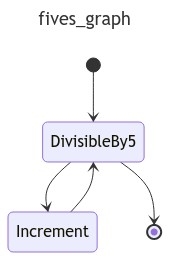

In [198]:
from IPython.display import Image, display

display(Image(fives_graph.mermaid_image(start_node=DivisibleBy5)))


In [199]:
from __future__ import annotations

from dataclasses import dataclass

from rich.prompt import Prompt

from pydantic_graph import BaseNode, End, Graph, GraphRunContext


@dataclass
class MachineState:  
    user_balance: float = 0.0
    product: str | None = None


@dataclass
class InsertCoin(BaseNode[MachineState]):  
    async def run(self, ctx: GraphRunContext[MachineState]) -> CoinsInserted:  
        return CoinsInserted(float(Prompt.ask('Insert coins')))  


@dataclass
class CoinsInserted(BaseNode[MachineState]):
    amount: float  

    async def run(
        self, ctx: GraphRunContext[MachineState]
    ) -> SelectProduct | Purchase:  
        ctx.state.user_balance += self.amount  
        if ctx.state.product is not None:  
            return Purchase(ctx.state.product)
        else:
            return SelectProduct()


@dataclass
class SelectProduct(BaseNode[MachineState]):
    async def run(self, ctx: GraphRunContext[MachineState]) -> Purchase:
        return Purchase(Prompt.ask('Select product'))


PRODUCT_PRICES = {  
    'water': 1.25,
    'soda': 1.50,
    'crisps': 1.75,
    'chocolate': 2.00,
}


@dataclass
class Purchase(BaseNode[MachineState, None, None]):  
    product: str

    async def run(
        self, ctx: GraphRunContext[MachineState]
    ) -> End | InsertCoin | SelectProduct:
        if price := PRODUCT_PRICES.get(self.product):  
            ctx.state.product = self.product  
            if ctx.state.user_balance >= price:  
                ctx.state.user_balance -= price
                return End(None)
            else:
                diff = price - ctx.state.user_balance
                print(f'Not enough money for {self.product}, need {diff:0.2f} more')
                #> Not enough money for crisps, need 0.75 more
                return InsertCoin()  
        else:
            print(f'No such product: {self.product}, try again')
            return SelectProduct()  


vending_machine_graph = Graph(  
    nodes=[InsertCoin, CoinsInserted, SelectProduct, Purchase]
)


state = MachineState()  
await vending_machine_graph.run(InsertCoin(), state=state)  
print(f'purchase successful item={state.product} change={state.user_balance:0.2f}')
#> purchase successful item=crisps change=0.25

Insert coins:

Select product:

purchase successful item=water change=2.75


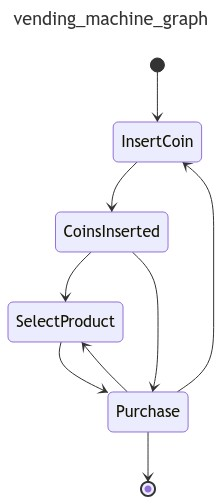

In [202]:
display(Image(vending_machine_graph.mermaid_image(start_node=InsertCoin)))


In [210]:
from __future__ import annotations as _annotations

from dataclasses import dataclass, field

from pydantic import BaseModel, EmailStr

from pydantic_ai import Agent
from pydantic_ai.format_as_xml import format_as_xml
from pydantic_ai.messages import ModelMessage
from pydantic_graph import BaseNode, End, Graph, GraphRunContext


@dataclass
class User:
    name: str
    email: EmailStr
    interests: list[str]


@dataclass
class Email:
    subject: str
    body: str


@dataclass
class State:
    user: User
    write_agent_messages: list[ModelMessage] = field(default_factory=list)


email_writer_agent = Agent(
    'google-gla:gemini-2.0-flash',
    result_type=Email,
    system_prompt='Write a welcome email to our tech blog.',
)


@dataclass
class WriteEmail(BaseNode[State]):
    email_feedback: str | None = None

    async def run(self, ctx: GraphRunContext[State]) -> Feedback:
        if self.email_feedback:
            prompt = (
                f'Rewrite the email for the user:\n'
                f'{format_as_xml(ctx.state.user)}\n'
                f'Feedback: {self.email_feedback}'
            )
        else:
            prompt = (
                f'Write a welcome email for the user:\n'
                f'{format_as_xml(ctx.state.user)}'
            )

        result = await email_writer_agent.run(
            prompt,
            message_history=ctx.state.write_agent_messages,
        )
        ctx.state.write_agent_messages += result.all_messages()
        return Feedback(result.data)


class EmailRequiresWrite(BaseModel):
    feedback: str


class EmailOk(BaseModel):
    pass


feedback_agent = Agent[None, EmailRequiresWrite | EmailOk](
    'google-gla:gemini-2.0-flash',
    result_type=EmailRequiresWrite | EmailOk,  # type: ignore
    system_prompt=(
        'Review the email and provide feedback, email must reference the users specific interests.'
    ),
)


@dataclass
class Feedback(BaseNode[State, None, Email]):
    email: Email

    async def run(
        self,
        ctx: GraphRunContext[State],
    ) -> WriteEmail | End[Email]:
        prompt = format_as_xml({'user': ctx.state.user, 'email': self.email})
        result = await feedback_agent.run(prompt)
        if isinstance(result.data, EmailRequiresWrite):
            return WriteEmail(email_feedback=result.data.feedback)
        else:
            return End(self.email)


user = User(
    name='John Doe',
    email='john.joe@example.com',
    interests=['Haskel', 'Lisp', 'Fortran'],
)
state = State(user)
feedback_graph = Graph(nodes=(WriteEmail, Feedback))
#email, _ = await feedback_graph.run(WriteEmail(), state=state)
#print(email)
"""
Email(
    subject='Welcome to our tech blog!',
    body='Hello John, Welcome to our tech blog! ...',
)
""";

result = await feedback_graph.run(WriteEmail(), state=state)

In [222]:
feedback_agent._system_prompts[0]

('Review the email and provide feedback, email must reference the users specific interests.',)

In [223]:
agent.run_stream?

Signature:
agent.run_stream(
    user_prompt: 'str',
    *,
    result_type: 'type[RunResultDataT] | None' = None,
    message_history: 'list[_messages.ModelMessage] | None' = None,
    model: 'models.Model | models.KnownModelName | None' = None,
    deps: 'AgentDepsT' = None,
    model_settings: 'ModelSettings | None' = None,
    usage_limits: '_usage.UsageLimits | None' = None,
    usage: '_usage.Usage | None' = None,
    infer_name: 'bool' = True,
) -> 'AsyncIterator[result.StreamedRunResult[AgentDepsT, Any]]'
Docstring:
Run the agent with a user prompt in async mode, returning a streamed response.

Example:
```python
from pydantic_ai import Agent

agent = Agent('openai:gpt-4o')

async def main():
    async with agent.run_stream('What is the capital of the UK?') as response:
        print(await response.get_data())
        #> London
```

Args:
    result_type: Custom result type to use for this run, `result_type` may only be used if the agent has no
        result validators since r

Object `result1.stream_text` not found.
